In [1]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
import glob, os, json
import scipy.linalg as sl
from scipy import stats as scistats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 2.5 * matplotlib.rcParams['figure.dpi']

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise import constants as const
from enterprise.signals import prior

import libstempo as T2, libstempo.toasim as LT

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [2]:
def get_planet_orbital_elements():
    """Grab physical ephemeris model files"""
    dpath = enterprise.__path__[0] + '/datafiles/ephemeris/'
    jup_mjd = np.load(dpath + 'jupiter-orbel-mjd.npy')
    jup_orbelxyz = np.load(dpath + 'jupiter-orbel-xyz-svd.npy')
    sat_mjd = np.load(dpath + 'saturn-orbel-mjd.npy')
    sat_orbelxyz = np.load(dpath + 'saturn-orbel-xyz-svd.npy')
    return jup_mjd, jup_orbelxyz, sat_mjd, sat_orbelxyz

In [3]:
def get_inpop_planet_orbital_elements():
    """Grab physical ephemeris model files"""
    dpath = '/Users/staylor/Research/bayes_ephem_project/data/inpop_partials/'
    jup_mjd = np.load(dpath + 'jupiter/jupiter-inpop-mjd.npy')
    jup_orbelxyz = np.load(dpath + 'jupiter/jupiter-inpop-xyz.npy')
    return jup_mjd, jup_orbelxyz

In [6]:
@signal_base.function
def physical_ephem_delay(toas, planetssb, pos_t, frame_drift_rate=0,
                         d_jupiter_mass=0, d_saturn_mass=0, d_uranus_mass=0,
                         d_neptune_mass=0, jup_orb_elements=np.zeros(6),
                         sat_orb_elements=np.zeros(6), inc_jupiter_orb=False,
                         jup_orbelxyz=None, jup_mjd=None, inc_saturn_orb=False,
                         sat_orbelxyz=None, sat_mjd=None, equatorial=True):

    # convert toas to MJD
    mjd = toas / 86400

    # grab planet-to-SSB vectors
    earth = planetssb[:, 2, :3]
    jupiter = planetssb[:, 4, :3]
    saturn = planetssb[:, 5, :3]
    uranus = planetssb[:, 6, :3]
    neptune = planetssb[:, 7, :3]

    # do frame rotation
    earth = utils.ss_framerotate(mjd, earth, 0.0, 0.0, 0.0, frame_drift_rate,
                           offset=None, equatorial=equatorial)

    # mass perturbations
    mpert = [(jupiter, d_jupiter_mass), (saturn, d_saturn_mass),
             (uranus, d_uranus_mass), (neptune, d_neptune_mass)]
    for planet, dm in mpert:
        earth += utils.dmass(planet, dm)

    # jupter orbital element perturbations
    if inc_jupiter_orb:
        jup_perturb_tmp = 0.0009547918983127075 * np.einsum(
            'i,ijk->jk', jup_orb_elements, jup_orbelxyz)
        earth += np.array([np.interp(mjd, jup_mjd, jup_perturb_tmp[:,aa])
                           for aa in range(3)]).T

    # saturn orbital element perturbations
    if inc_saturn_orb:
        sat_perturb_tmp = 0.00028588567008942334 * np.einsum(
            'i,ijk->jk', sat_orb_elements, sat_orbelxyz)
        earth += np.array([np.interp(mjd, sat_mjd, sat_perturb_tmp[:,aa])
                           for aa in range(3)]).T

    # construct the true geocenter to barycenter roemer
    tmp_roemer = np.einsum('ij,ij->i', planetssb[:, 2, :3], pos_t)

    # create the delay
    delay = tmp_roemer - np.einsum('ij,ij->i', earth, pos_t)

    return delay

In [7]:
@signal_base.function
def dynamic_physical_ephem_delay(toas, planetssb, pos_t, frame_drift_rate=0,
                                 d_jupiter_mass=0, d_saturn_mass=0, d_uranus_mass=0,
                                 d_neptune_mass=0, 
                                 inc_jupiter_orb=False, jup_orb_elements=np.zeros(6),
                                 jup_orbelxyz=None, jup_mjd=None, 
                                 inc_jupitersun_orb=False,
                                 jupsun_orb_elements=np.zeros(12),
                                 jupsun_orbelxyz=None, jupsun_mjd=None, 
                                 equatorial=True):

    # convert toas to MJD
    mjd = toas / 86400

    # grab planet-to-SSB vectors
    earth = planetssb[:, 2, :3]
    jupiter = planetssb[:, 4, :3]
    saturn = planetssb[:, 5, :3]
    uranus = planetssb[:, 6, :3]
    neptune = planetssb[:, 7, :3]

    # do frame rotation
    earth = utils.ss_framerotate(mjd, earth, 0.0, 0.0, 0.0, frame_drift_rate,
                           offset=None, equatorial=equatorial)

    # mass perturbations
    mpert = [(jupiter, d_jupiter_mass), (saturn, d_saturn_mass),
             (uranus, d_uranus_mass), (neptune, d_neptune_mass)]
    for planet, dm in mpert:
        earth += utils.dmass(planet, dm)

    if inc_jupiter_orb:
        # jupter orbital element perturbations
        jup_perturb_tmp =  np.einsum('i,ijk->jk', 
                                     jup_orb_elements, 
                                     jup_orbelxyz)
        earth += np.array([np.interp(mjd, jup_mjd, 
                                     jup_perturb_tmp[:,aa])
                           for aa in range(3)]).T
    elif inc_jupitersun_orb:
        # jupter-sun orbital element perturbations
        jupsun_perturb_tmp =  np.einsum('i,ijk->jk', 
                                        jupsun_orb_elements, 
                                        jupsun_orbelxyz)
        earth += np.array([np.interp(mjd, jupsun_mjd, 
                                     jupsun_perturb_tmp[:,aa])
                           for aa in range(3)]).T
        
    # construct the true geocenter to barycenter roemer
    tmp_roemer = np.einsum('ij,ij->i', planetssb[:, 2, :3], pos_t)

    # create the delay
    delay = tmp_roemer - np.einsum('ij,ij->i', earth, pos_t)

    return delay

In [112]:
def DynamicPhysicalEphemerisSignal(
    frame_drift_rate=parameter.Constant(0)('frame_drift_rate'),
    d_jupiter_mass=parameter.Normal(0, 1.54976690e-11)('d_jupiter_mass'),
    d_saturn_mass=parameter.Normal(0, 8.17306184e-12)('d_saturn_mass'),
    d_uranus_mass=parameter.Normal(0, 5.71923361e-11)('d_uranus_mass'),
    d_neptune_mass=parameter.Normal(0, 7.96103855e-11)('d_neptune_mass'),
    jup_orb_elements=parameter.Uniform(-1e-4,1e-4,size=6)('jup_orb_elements'),
    jupsun_orb_elements=parameter.Uniform(-1e-4,1e-4,size=12)('jupsun_orb_elements'),
    inc_jupiter_orb=True, inc_jupitersun_orb=False, use_epoch_toas=True,
    name=''): 

    """ Class factory for dynamic physical ephemeris model signal.

    This function implements a physically motivated ephemeris delay model.
    It is parameterized by an overall frame drift rate, masses of gas giants,
    6/12 orbital elements of Jupiter/Jupiter-Sun (uses a PCA basis)

    .. note:: This signal is only compatible with a tempo2 Pulsar object.

    The user can implement their own priors but we have set reasonable
    defaults.

    :param frame_drift_rate:
        ecliptic z-drift rate in units of rad/year referred to offset 1/1/2010.
        Default prior is Uniform(-1e-9, 1e-9).

    :param d_jupiter_mass:
        Mass deviation of jupiter in solar masses. Default prior taken from
        IAU mass measurement uncertainty - Normal(0, 1.54976690e-11)

    :param d_saturn_mass:
        Mass deviation of saturn in solar masses. Default prior taken from
        IAU mass measurement uncertainty - Normal(0, 8.17306184e-12)

    :param d_uranus_mass:
        Mass deviation of uranus in solar masses. Default prior taken from
        IAU mass measurement uncertainty - Normal(0, 5.71923361e-11)

    :param d_neptune_mass:
        Mass deviation of neptune in solar masses. Default prior taken from
        IAU mass measurement uncertainty - Normal(0, 7.96103855e-11)

    :param jup_orb_elements:
        Amplitudes of PCA basis of jupiter orbital elements including
        (1) semi-major axis
        (2) eccentricity
        (3) inclination
        (4) longitude of the ascending node
        (5) longitude of perihelion
        (6) mean longitude

        Default prior is Uniform(-0.05, 0.05) for each element.
        
    :param jupsun_orb_elements:
        Amplitudes of PCA basis of jupiter-sun orbital elements including
        (1) semi-major axis
        (2) eccentricity
        (3) inclination
        (4) longitude of the ascending node
        (5) longitude of perihelion
        (6) mean longitude

        Default prior is Uniform(-0.05, 0.05) for each element.

    :param use_epoch_toas:
        Use interprolation from epoch to full TOAs. This option reduces
        computational cost for large multi-channel TOA data sets.
        Default: True
    """
    
    # turn off jupiter orbital element parameters if not including in signal
    if not inc_jupiter_orb:
        jup_orb_elements = np.zeros(6)
        
    # turn off jupiter-sun orbital element parameters if not including in signal
    if not inc_jupitersun_orb:
        jupsun_orb_elements = np.zeros(12)

    # define waveform
    jup_mjd, jup_orbelxyz, jupsun_mjd, jupsun_orbelxyz = (get_dynamic_planet_orbital_elements())
    wf = dynamic_physical_ephem_delay(frame_drift_rate=frame_drift_rate,
                                    d_jupiter_mass=d_jupiter_mass,
                                    d_saturn_mass=d_saturn_mass,
                                    d_uranus_mass=d_uranus_mass,
                                    d_neptune_mass=d_neptune_mass,
                                    jup_orb_elements=jup_orb_elements,
                                    jupsun_orb_elements=jupsun_orb_elements,
                                    inc_jupiter_orb=inc_jupiter_orb,
                                    inc_jupitersun_orb=inc_jupitersun_orb,
                                    jup_orbelxyz=jup_orbelxyz,
                                    jup_mjd=jup_mjd,
                                    jupsun_orbelxyz=jupsun_orbelxyz,
                                    jupsun_mjd=jupsun_mjd)

    BaseClass = Deterministic(wf, name=name)

    class DynamicPhysicalEphemerisSignal(BaseClass):
        signal_name = 'phys_ephem'
        signal_id = 'phys_ephem_' + name if name else 'phys_ephem'

        def __init__(self, psr):

            # not available for PINT yet
            if isinstance(psr, enterprise.pulsar.PintPulsar):
                msg = 'Dynamic Physical Ephemeris model is not compatible with PINT '
                msg += 'at this time.'
                raise NotImplementedError(msg)

            super(DynamicPhysicalEphemerisSignal, self).__init__(psr)

            if use_epoch_toas:
                # get quantization matrix and calculate daily average TOAs
                U, _ = utils.create_quantization_matrix(psr.toas, nmin=1)
                self.uinds = utils.quant2ind(U)
                avetoas = np.array([psr.toas[sc].mean() for sc in self.uinds])
                self._wf[''].add_kwarg(toas=avetoas)

                # interpolate ssb planet position vectors to avetoas
                planetssb = np.zeros((len(avetoas), 9, 3))
                for jj in range(9):
                    planetssb[:, jj, :] = np.array([
                        np.interp(avetoas, psr.toas, psr.planetssb[:,jj,aa])
                        for aa in range(3)]).T
                self._wf[''].add_kwarg(planetssb=planetssb)

                # Inteprolating the pulsar position vectors onto epoch TOAs
                pos_t = np.array([np.interp(avetoas, psr.toas, psr.pos_t[:,aa])
                                  for aa in range(3)]).T
                self._wf[''].add_kwarg(pos_t=pos_t)

            # initialize delay
            self._delay = np.zeros(len(psr.toas))

        @base.cache_call('delay_params')
        def get_delay(self, params):
            delay = self._wf[''](params=params)
            if use_epoch_toas:
                for slc, val in zip(self.uinds, delay):
                    self._delay[slc] = val
                return self._delay
            else:
                return delay

    return DynamicPhysicalEphemerisSignal

In [113]:
def model_2a_dynamic(psrs, psd='powerlaw', noisedict=None, components=30,
             gamma_common=None, upper_limit=False, bayesephem=False,
             wideband=False):
    """
    Reads in list of enterprise Pulsar instance and returns a PTA
    instantiated with model 2A from the analysis paper:

    per pulsar:
        1. fixed EFAC per backend/receiver system
        2. fixed EQUAD per backend/receiver system
        3. fixed ECORR per backend/receiver system
        4. Red noise modeled as a power-law with 30 sampling frequencies
        5. Linear timing model.

    global:
        1.Common red noise modeled with user defined PSD with
        30 sampling frequencies. Available PSDs are
        ['powerlaw', 'turnover' 'spectrum']
        2. Optional physical ephemeris modeling.

    :param psd:
        PSD to use for common red noise signal. Available options
        are ['powerlaw', 'turnover' 'spectrum']. 'powerlaw' is default
        value.
    :param noisedict:
        Dictionary of pulsar noise properties. Can provide manually,
        or the code will attempt to find it.
    :param gamma_common:
        Fixed common red process spectral index value. By default we
        vary the spectral index over the range [0, 7].
    :param upper_limit:
        Perform upper limit on common red noise amplitude. By default
        this is set to False. Note that when perfoming upper limits it
        is recommended that the spectral index also be fixed to a specific
        value.
    :param bayesephem:
        Include (Dynamic) BayesEphem model. Set to False by default
    :param wideband:
        Use wideband par and tim files. Ignore ECORR. Set to False by default.
    """

    amp_prior = 'uniform' if upper_limit else 'log-uniform'

    # find the maximum time span to set GW frequency sampling
    Tspan = model_utils.get_tspan(psrs)

    # white noise
    s = white_noise_block(vary=False, wideband=wideband)

    # red noise
    s += red_noise_block(prior=amp_prior, Tspan=Tspan, components=components)

    # common red noise block
    s += common_red_noise_block(psd=psd, prior=amp_prior, Tspan=Tspan,
                                components=components, gamma_val=gamma_common,
                                name='gw')

    # ephemeris model
    if bayesephem:
        s += DynamicPhysicalEphemerisSignal(use_epoch_toas=True)

    # timing model
    s += gp_signals.TimingModel()

    # set up PTA
    pta = signal_base.PTA([s(psr) for psr in psrs])

    # set white noise parameters
    if noisedict is None:
        print('No noise dictionary provided!...')
    else:
        noisedict = noisedict
        pta.set_default_params(noisedict)

    return pta

In [ ]:
# Read in arguments

parser = argparse.ArgumentParser()

parser.add_argument("--ephem", type=str, default='DE436',
                        help="Which JPL Ephemeris model to use? [default=DE436]")
parser.add_argument("--bayesephem", action="store_true", default=False,
                        help="Use BayesEphem? [default=False]")
parser.add_argument("--limit", action="store_true", default=False,
                        help="Run an upper-limit analysis [default=False]")
parser.add_argument("--gamma_common", type=float, default=None,
                        help="Fix the gamma index of a common red process [default=None]")
parser.add_argument("--psd", type=str, default='powerlaw',
                        help="What type of spectrum? [default=powerlaw]")
parser.add_argument("--components", type=int, default=30,
                        help="Number of frequency components for red spectra [default=30]")
parser.add_argument("--psrTerm", action="store_true", default=False,
                        help="Include pulsar term in CW searches? [default=False]")
parser.add_argument("--outdir", type=str,
                        default="../chains/",
                        help="Output directory for sampler")
parser.add_argument("--resume", action="store_true", default=False,
                        help="Resume sampler [default=False]")
parser.add_argument("--models", type=str, default=None,
                        help="List of model keywords [default=None]")
parser.add_argument("--start_time", type=float, default=None,
                        help="Start time for TOA filter [default=None]")
parser.add_argument("--end_time", type=float, default=None,
                        help="End time for TOA filter [default=None]")

args = parser.parse_args()

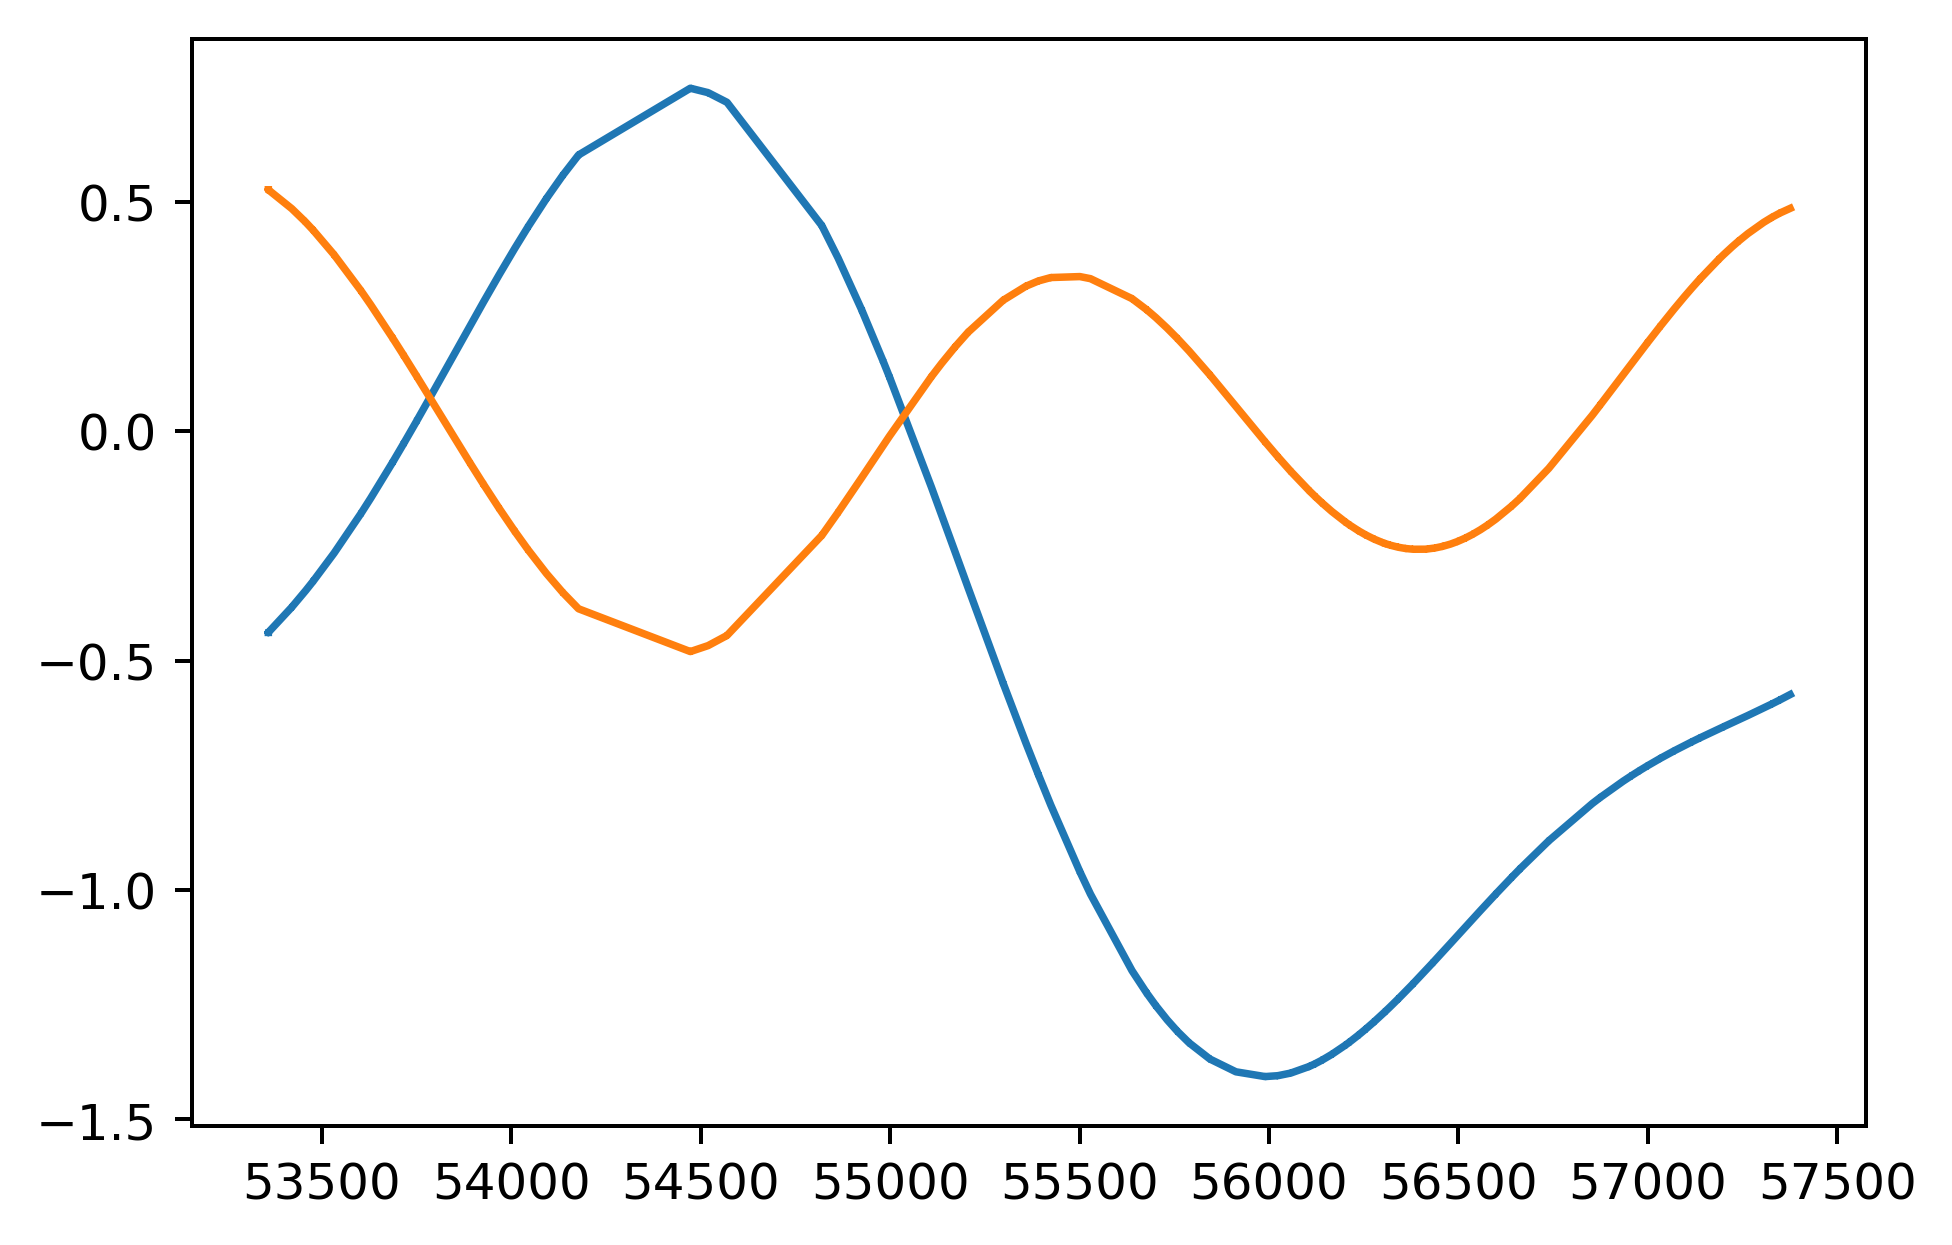

In [8]:
psr = Pulsar('../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.gls.par', 
             '../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.tim',
             ephem='DE436')

#jupel = np.random.uniform(-0.00005,0.00005,6)

jupel = np.random.uniform(-0.05,0.05,6)
jup_mjd, jup_orbelxyz, sat_mjd, sat_orbelxyz = (get_planet_orbital_elements())
test_orig = physical_ephem_delay(psr.toas, psr.planetssb, psr.pos_t, 
                                 jup_orb_elements=jupel, 
                                 inc_jupiter_orb=True, 
                                 jup_orbelxyz=jup_orbelxyz, jup_mjd=jup_mjd,)

jupel = np.random.uniform(-0.05,0.05,6)
jup_mjd_inpop, jup_orbelxyz_inpop = (get_inpop_planet_orbital_elements())
test_new = physical_ephem_delay(psr.toas, psr.planetssb, psr.pos_t, 
                                 jup_orb_elements=jupel, 
                                 inc_jupiter_orb=True, 
                                 jup_orbelxyz=jup_orbelxyz_inpop, jup_mjd=jup_mjd_inpop)

plt.plot(psr.toas/86400, test_orig/1e-6)
plt.plot(psr.toas/86400, test_new/1e-6)

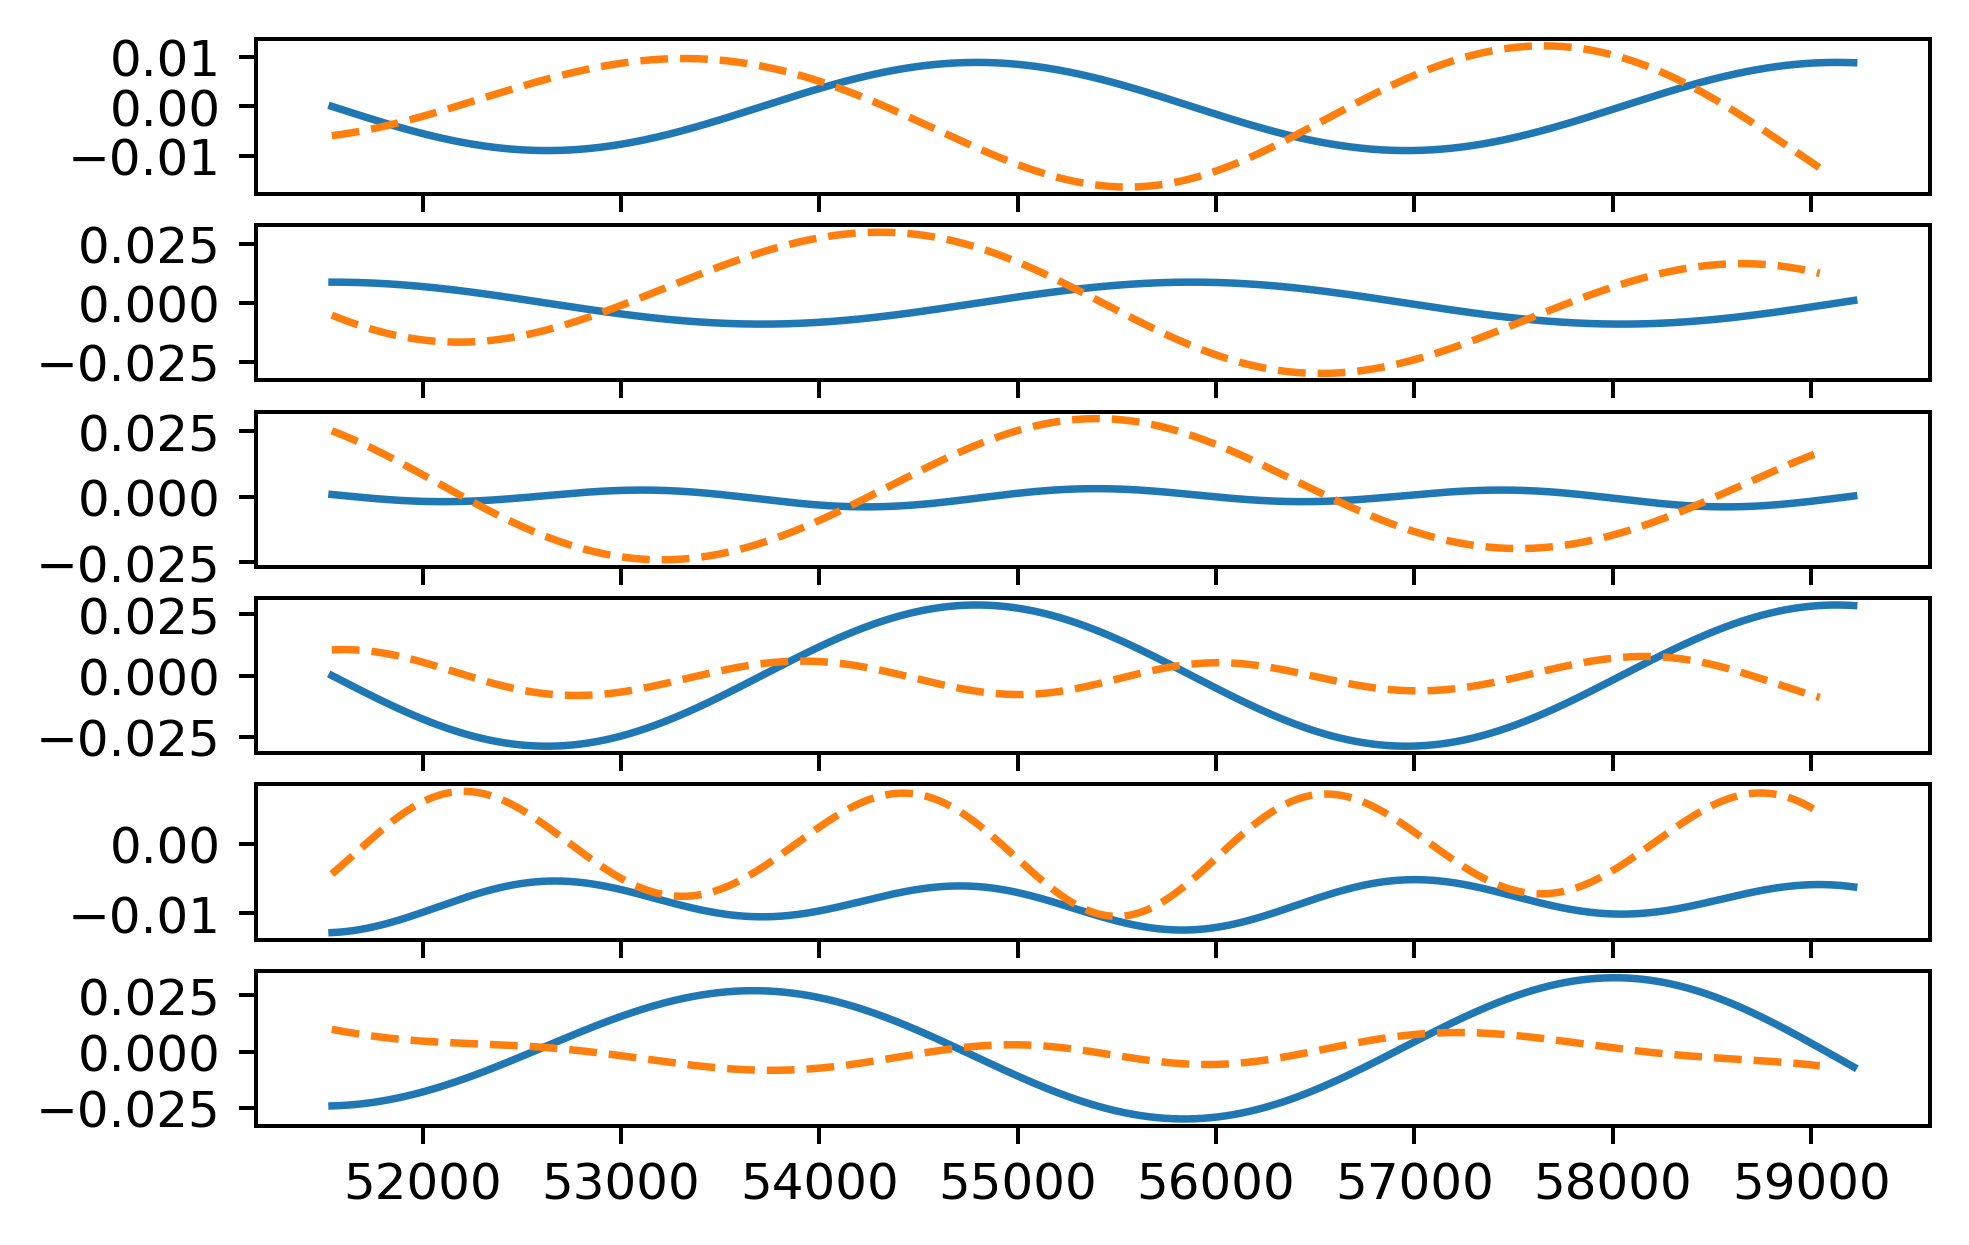

In [9]:
fig,ax = plt.subplots(nrows=6)

for ii in range(6):
    ax[ii].plot(jup_mjd,jup_orbelxyz[ii,:,2], linestyle='solid')
    ax[ii].plot(jup_mjd_inpop,jup_orbelxyz_inpop[ii,:,2], linestyle='dashed')

In [ ]:
## Data directory
datadir = '/home/stephen.taylor/NANOGrav/nano11yr_scripts/partim_no_noise'


## Grab par and tim files
psrlist = np.loadtxt('../11yr_stochastic_analysis/psrlist.txt', dtype=np.unicode_)

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

## Load into Pulsar class
psrs = []
for par, tim in zip(parfiles, timfiles):
    pname = par.split('/')[-1].split('_')[0]
    print pname
    if pname in psrlist:
        psr = Pulsar(par, tim, ephem=args.ephem)
        psrs.append(psr)

## Get parameter noise dictionary
noisefiles = sorted(glob.glob('../11yr_stochastic_analysis/nano11y_data/noisefiles/*.json'))

params = {}
for noisefil in noisefiles:
    with open(noisefil, 'r') as fp:
        params.update(json.load(fp))

## Set up model
pta = models.model_2a_dynamic(psrs, noisedict=params, psd='powerlaw', components=30,
                              gamma_common=args.gamma_common, upper_limit=False,
                              bayesephem=True)

outdir = './chains_nano11_tests/nano11_bayesephem_dynamic/jupiter/'
sampler = model_utils.setup_sampler(pta, resume=True, outdir=outdir)

N = int(5e6) # one mega-sample!
x0 = np.hstack(p.sample() for p in pta.params)

sampler.sample(x0, N, AMweight=25, SCAMweight=40, DEweight=55)

In [ ]:
psr = Pulsar('../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.gls.par', 
             '../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.tim',
             ephem='/Users/staylor/Downloads/inpop17a_TDB_m100_p100_spice/inpop17a_TDB_m100_p100_spice.bsp')

In [ ]:
T2.tempopulsar('../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.gls.par', 
             '../NANOGrav/11year_analysis/11yr_stochastic_analysis/nano11y_data/partim/B1855+09_NANOGrav_11yv0.tim',
             ephem='/Users/staylor/Downloads/inpop17a_TDB_m100_p100_spice/inpop17a_TDB_m100_p100_spice.bsp')